# <p style="text-align:center;">Random Forest</p>
This notebook explores the use of Random Forest models for forecasting the direction and magnitude of the difference between Spot and Intraday electricity prices. Both regression and classification approaches are implemented, with a focus on handling missing data and evaluating model performance using a custom weighted accuracy metric.

A Random Forest is an ensemble of decision trees, which improves predictive performance and robustness to overfitting. Here, we use Random Forests for both regression and classification to predict the direction and value of the spot-intraday price difference.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, roc_auc_score, roc_curve, make_scorer
from sklearn.tree import plot_tree

In [2]:
X_train = pd.read_csv(r"C:\Users\arman\Desktop\Power_Spot_Price_Forecasting\data\X_train.csv", index_col=0)
X_test = pd.read_csv(r"C:\Users\arman\Desktop\Power_Spot_Price_Forecasting\data\X_test.csv", index_col=0)
y_train = pd.read_csv(r"C:\Users\arman\Desktop\Power_Spot_Price_Forecasting\data\y_train.csv", index_col=0)
y_random = pd.read_csv(r"C:\Users\arman\Desktop\Power_Spot_Price_Forecasting\data\y_random.csv")
XY_train = pd.merge(X_train, y_train, left_index=True, right_index=True)

In [3]:
def weighted_accuracy(y_true, y_pred):
    mask = y_true != 0
    y_true_sign = np.sign(y_true[mask])
    y_pred_sign = np.sign(y_pred[mask])
    
    correct = y_true_sign == y_pred_sign
    weights = np.abs(y_true[mask])
    
    return np.sum(weights * correct) / np.sum(weights)

# Custom scorer for model selection
weighted_accuracy_scorer = make_scorer(weighted_accuracy, greater_is_better=True)

# Random Forest Regressor without predicted_spot_price

In [4]:
# Split the data for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
X_train_reg = X_train_reg.drop("predicted_spot_price", axis=1)
X_test_reg = X_test_reg.drop("predicted_spot_price", axis=1)
X_test_spot = X_test.copy()
X_test_spot = X_test_spot.drop("predicted_spot_price", axis=1)

In [5]:
# Grid search for best hyperparameters (regression)
rf_reg = RandomForestRegressor(random_state=42)
param_grid_rf_reg = {
    'n_estimators': [100, 200, 500],
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse'],
    'max_depth': [None, 10, 20, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5, None],
    'bootstrap': [True, False],
    'max_leaf_nodes': [None, 10, 50],
    'min_impurity_decrease': [0.0, 0.001]
}
grid_search_reg = GridSearchCV(
    estimator=rf_reg,
    param_grid=param_grid_rf_reg,
    scoring=weighted_accuracy_scorer,
    cv=5,
    n_jobs=-1,
    verbose=1
    )
grid_search_reg.fit(X_train_reg, y_train_reg['spot_id_delta'])

Fitting 5 folds for each of 15552 candidates, totalling 77760 fits


c:\Users\arman\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
25920 fits failed out of a total of 77760.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25920 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\arman\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\arman\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\arm

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['squared_error', 'absolute_error',
                                       'friedman_mse'],
                         'max_depth': [None, 10, 20, 50],
                         'max_features': ['sqrt', 'log2', 0.5, None],
                         'max_leaf_nodes': [None, 10, 50],
                         'min_impurity_decrease': [0.0, 0.001],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500]},
             scoring=make_scorer(weighted_accuracy, response_method='predict'),
             verbose=1)

In [6]:
# Display the best and top 10 hyperparameter sets (regression)
print("🌟 Best hyperparameters found:")
print(grid_search_reg.best_params_)
print("✅ Best weighted accuracy (cross-validation):", grid_search_reg.best_score_)

results_reg = pd.DataFrame(grid_search_reg.cv_results_)
results_reg_sorted = results_reg.sort_values(by='mean_test_score', ascending=False)
print("\nTop 10 hyperparameter sets:")
print(results_reg_sorted[['mean_test_score', 'params']].head(10).to_string(index=False))

🌟 Best hyperparameters found:
{'bootstrap': False, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 0.5, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
✅ Best weighted accuracy (cross-validation): 0.8732860519647673

Top 10 hyperparameter sets:
 mean_test_score                                                                                                                                                                                                                 params
        0.873286 {'bootstrap': False, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 0.5, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
        0.872987    {'bootstrap': False, 'criterion': 'friedman_mse', 'max_depth': 50, 'max_features': 0.5, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 1, 'min_sample

In [7]:
# Evaluate regression model with weighted accuracy, confusion matrix, and classification report
best_reg_model = grid_search_reg.best_estimator_
y_pred_reg = best_reg_model.predict(X_test_reg)
wa_score_reg = weighted_accuracy(y_test_reg['spot_id_delta'], y_pred_reg)
print(f"\n✅ Weighted Accuracy (test set): {wa_score_reg:.4f}")

y_test_sign_reg = (y_test_reg['spot_id_delta'] > 0).astype(int)
y_pred_sign_reg = (y_pred_reg > 0).astype(int)
print("\nConfusion Matrix (Predicted vs Actual Signs):")
print(confusion_matrix(y_test_sign_reg, y_pred_sign_reg))
print("\nClassification Report:")
print(classification_report(y_test_sign_reg, y_pred_sign_reg))


✅ Weighted Accuracy (test set): 0.8808

Confusion Matrix (Predicted vs Actual Signs):
[[785 281]
 [218 837]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.74      0.76      1066
           1       0.75      0.79      0.77      1055

    accuracy                           0.76      2121
   macro avg       0.77      0.76      0.76      2121
weighted avg       0.77      0.76      0.76      2121



🎯 AUC Score (positive sign): 0.8416


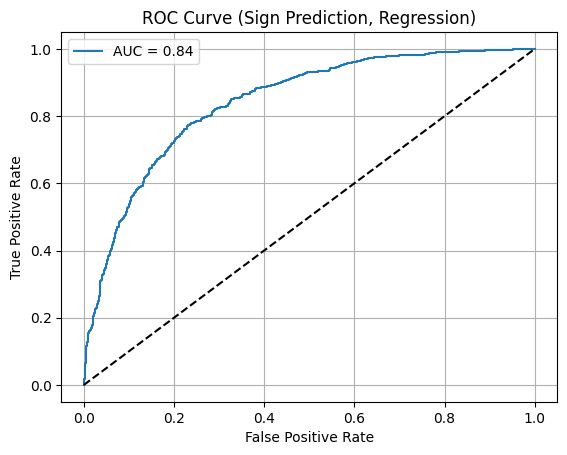

In [8]:
# ROC curve and AUC for regression
from sklearn.preprocessing import label_binarize
y_score_reg = y_pred_reg  # continuous output from regressor
y_test_bin_reg = label_binarize((y_test_sign_reg > 0).astype(int), classes=[0, 1])
auc_reg = roc_auc_score(y_test_bin_reg, y_score_reg)
print(f"🎯 AUC Score (positive sign): {auc_reg:.4f}")

fpr_reg, tpr_reg, _ = roc_curve(y_test_bin_reg, y_score_reg)
plt.figure()
plt.plot(fpr_reg, tpr_reg, label=f"AUC = {auc_reg:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Sign Prediction, Regression)")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Predict on the test set and export results (regression)
y_pred_reg_CV = best_reg_model.predict(X_test_spot)
y_output_reg_CV = y_random.copy()
y_output_reg_CV['spot_id_delta'] = y_pred_reg_CV
y_output_reg_CV.head()
y_output_reg_CV.to_csv(r"C:\Users\arman\Desktop\Power_Spot_Price_Forecasting\output\y_output_reg_random_forest.csv", index=False)

# Random Forest Classifier without predicted_spot_price

In [ ]:
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
X_train_clf = X_train_clf.drop("predicted_spot_price", axis=1)
X_test_clf = X_test_clf.drop("predicted_spot_price", axis=1)
X_test_spot = X_test.copy()
X_test_spot = X_test_spot.drop("predicted_spot_price", axis=1)

In [ ]:
# Grid search for best hyperparameters (classification)
rf_clf = RandomForestClassifier(random_state=42)
param_grid_rf_clf = {
    'n_estimators': [100, 200, 500],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 10, 20, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 10, 20],
    'max_features': [None, 'sqrt', 'log2', 0.5],
    'bootstrap': [True, False],
    'max_leaf_nodes': [None, 10, 20, 50, 100],
    'min_weight_fraction_leaf': [0.0, 0.01, 0.05],
    'class_weight': [None, 'balanced'],
    'ccp_alpha': [0.0, 0.01, 0.02, 0.05, 0.1]
}
grid_search_clf = GridSearchCV(
    estimator=rf_clf,
    param_grid=param_grid_rf_clf,
    scoring=weighted_accuracy_scorer,
    cv=5,
    n_jobs=-1,
    verbose=1
    )
grid_search_clf.fit(X_train_clf, y_train_clf)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_features=None, min_samples_leaf=10, n_jobs=-1,
                       random_state=42)

In [ ]:
# Display the best and top 10 hyperparameter sets (classification)
print("🌟 Best hyperparameters found:")
print(grid_search_clf.best_params_)
print("✅ Best weighted accuracy (cross-validation):", grid_search_clf.best_score_)

results_clf = pd.DataFrame(grid_search_clf.cv_results_)
results_clf_sorted = results_clf.sort_values(by='mean_test_score', ascending=False)
print("\nTop 10 hyperparameter sets:")
print(results_clf_sorted[['mean_test_score', 'params']].head(10).to_string(index=False))

In [ ]:
# Evaluate classifier model with weighted accuracy, confusion matrix, and classification report
best_clf_model = grid_search_clf.best_estimator_
y_pred_clf = best_clf_model.predict(X_test_clf)
wa_score_clf = weighted_accuracy(y_test_clf, y_pred_clf)
print(f"\n✅ Weighted Accuracy (test set): {wa_score_clf:.4f}")

print("\nConfusion Matrix (Predicted vs Actual Signs):")
print(confusion_matrix(y_test_clf, y_pred_clf))
print("\nClassification Report:")
print(classification_report(y_test_clf, y_pred_clf))

In [ ]:
# ROC curve and AUC for classifier
if hasattr(best_clf_model, 'predict_proba'):
    proba_index = list(best_clf_model.classes_).index(1)
    y_pred_proba_clf = best_clf_model.predict_proba(X_test_clf)[:, proba_index]
    auc_score_clf = roc_auc_score(y_test_clf, y_pred_proba_clf)
    print(f"🎯 AUC Score (positive sign): {auc_score_clf:.4f}")
    fpr_clf, tpr_clf, _ = roc_curve(y_test_clf, y_pred_proba_clf)
    plt.figure()
    plt.plot(fpr_clf, tpr_clf, label=f"AUC = {auc_score_clf:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Classification)")
    plt.legend()
    plt.grid(True)
    plt.show()

NameError: name 'best_clf_model' is not defined

In [ ]:
# Predict on the test set and export results (classification)
y_pred_class_CV = rf_clf.predict(X_test_spot_clf)
y_output_class_CV = y_random.copy()
y_output_class_CV['spot_id_delta'] = y_pred_class_CV
y_output_class_CV.head()
y_output_class_CV.to_csv(r"C:\Users\arman\Desktop\Power_Spot_Price_Forecasting\output\y_output_class_random_forest.csv", index=False)